In [2]:
import pandas as pd
import numpy as np
from llama_index.embeddings.ollama import OllamaEmbedding
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle

class Toxic_Rail:
    """
    A class to handle training and prediction of toxicity in comments using embeddings and a Random Forest classifier.

    Attributes:
    embed_model (OllamaEmbedding): The embedding model used for generating text embeddings.
    model (RandomForestClassifier): The trained Random Forest model for prediction.
    df_train (DataFrame): The prepared training data.
    """

    def __init__(self, mode, input_path=None):
        """
        Initializes the Toxic_Rail class with either training or prediction mode.

        Args:
        mode (str): The mode of operation, either "train" or "predict".
        input_path (str, optional): The path to the input CSV file for training.
        """
        self.embed_model = OllamaEmbedding(model_name="mxbai-embed-large:latest")
        self.X = pd.DataFrame([])
        if mode == "train":
            self.X, self.model = self.train(input_path, "model/clf.mdl")
        if mode == "predict":
            self.model = pickle.load(open("model/clf.mdl", "rb"))
        if mode == "evaluate":
            self.model = pickle.load(open("model/clf.mdl", "rb"))
            self.evaluate(input_path)

    def evaluate(self, test_path):
        tqdm.pandas()
        df_test = self.prepare_data(test_path)
        embeddings = df_test['comment_text'].progress_apply(self.get_embeddings)
        columns = ["embed_" + str(i) for i in range(len(embeddings[0]))]
        X_test = pd.DataFrame(embeddings.tolist(), columns=columns)
        y_test = df_test['label']
        score = self.model.score(X_test, y_test)
        auc_val = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
        return score, auc_val
        

    def train(self, input_path, model_persist_path):
        """
        Trains the Random Forest model on the provided dataset and saves the model.

        Args:
        input_path (str): The path to the input CSV file for training.
        model_persist_path (str): The path where the trained model will be saved.
        """
        tqdm.pandas()
        self.df_train = self.prepare_data(input_path)
        embeddings = self.df_train['comment_text'].progress_apply(self.get_embeddings)
        columns = ["embed_" + str(i) for i in range(len(embeddings[0]))]
        X = pd.DataFrame(embeddings.tolist(), columns=columns)
        y = self.df_train['label']
        clf = RandomForestClassifier(max_depth=16, random_state=0).fit(X, y)
        print(clf.score(X, y))
        pickle.dump(clf, open(model_persist_path, "wb"))
        return X, clf

    def predict(self, text):
        """
        Predicts the toxicity label for a given text using the trained model.

        Args:
        text (str): The text to be classified.

        Returns:
        array: The predicted label for the input text.
        """
        test_embed = self.embed_model.get_text_embedding(text)
        column_names = ["embed_" + str(i) for i in range(len(test_embed))]
        X_test = pd.DataFrame([test_embed], columns=column_names)
        return self.model.predict(X_test)

    def create_label(self, row):
        """
        Creates a combined label for a row of the dataset based on individual toxicity indicators.

        Args:
        row (Series): A row from the dataset.

        Returns:
        str: The combined label for the row.
        """
        label = "|"
        if row["toxic"] == 1:
            label += "toxic|"
        if row["severe_toxic"] == 1:
            label += "severe_toxic|"
        if row["obscene"] == 1:
            label += "obscene|"
        if row["threat"] == 1:
            label += "threat|"
        if row["insult"] == 1:
            label += "insult|"
        if row["identity_hate"] == 1:
            label += "identity_hate|"
        if label == "|":
            label = "|non_toxic|"
        return label

    def get_embeddings(self, text):
        """
        Generates embeddings for a given text using the embedding model.

        Args:
        text (str): The text to be embedded.

        Returns:
        list: The embedding of the text.
        """
        return self.embed_model.get_text_embedding(text=text)

    def prepare_data(self, input_path):
        """
        Prepares the training data by reading from a CSV file, creating labels, 
        and balancing the dataset. The original dataset from here - 
        https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data

        Args:
        input_path (str): The path to the input CSV file.

        Returns:
        DataFrame: The prepared training data.
        """
        df = pd.read_csv(input_path)
        df["label"] = df.progress_apply(self.create_label, axis=1)
        toxic_df = df.iloc[np.where(df["label"] != "|non_toxic|")]
        non_toxic_df = df.iloc[np.where(df["label"] == "|non_toxic|")].head(10000)
        df = pd.concat([toxic_df, non_toxic_df], ignore_index=True, sort=False)
        return df

/Users/rspamzn/Documents/DevAx/Trainings/NN/agentic_rag/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
toxic_rail = Toxic_Rail(mode="train", input_path="data/toxic_train.csv")

100%|██████████| 26225/26225 [30:16<00:00, 14.44it/s]  


0.9953479504289799


In [6]:
features = pd.Series(toxic_rail.model.feature_importances_, index=toxic_rail.model.feature_names_in_)
sig_features = features.sort_values(ascending=False)
sig_features[:25]

embed_854     0.007582
embed_106     0.007359
embed_306     0.006848
embed_819     0.006760
embed_494     0.006232
embed_630     0.005752
embed_236     0.005686
embed_261     0.005332
embed_832     0.005287
embed_919     0.004656
embed_457     0.004328
embed_655     0.003577
embed_905     0.003530
embed_17      0.003521
embed_430     0.003410
embed_929     0.003219
embed_339     0.002928
embed_502     0.002900
embed_595     0.002873
embed_170     0.002831
embed_1019    0.002826
embed_807     0.002765
embed_644     0.002750
embed_862     0.002725
embed_769     0.002691
dtype: float64

In [7]:
toxic_rail.X

,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,...,embed_1014,embed_1015,embed_1016,embed_1017,embed_1018,embed_1019,embed_1020,embed_1021,embed_1022,embed_1023
0,-0.559703,-0.669759,-0.175383,-0.221705,0.648135,-1.312109,-0.730934,-0.185177,1.163031,-0.127197,...,0.745234,-0.166886,-0.564458,-0.836761,0.800905,0.970280,0.534051,-0.848159,0.412256,0.082659
1,0.247938,-0.678842,-1.381081,1.039240,0.048420,-0.200066,-0.553193,0.365013,0.341470,0.596931,...,0.840436,-0.103053,-0.189765,-0.979077,0.763938,0.191320,0.631293,-0.154026,-0.296055,0.104142
2,0.675798,-0.055785,-0.606153,0.980382,-1.191832,-0.336259,0.133880,0.409973,0.180909,0.371286,...,0.200143,-0.525673,-0.818838,-0.480613,0.574113,0.930501,0.114057,-1.393473,0.065175,-0.661573
3,0.451410,-0.873480,-0.214733,0.065568,-0.903386,-0.508580,0.424320,0.237534,-0.090481,0.593937,...,0.899135,-0.080831,-0.643658,0.389725,0.113793,0.694545,-0.644641,-0.972839,-0.609438,-0.524832
4,-0.114546,-0.576298,-0.466338,-0.239953,0.764013,-1.063667,-0.004036,-0.081846,0.434870,-0.105415,...,1.071483,0.289910,-0.306454,-1.077643,0.782038,0.707355,0.132532,-0.707682,-0.125300,0.496035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26220,1.187681,-0.850408,-0.022889,0.983352,-0.340956,0.040244,0.077518,0.395157,-0.364817,0.969535,...,0.554208,0.123095,0.180970,-0.428972,0.778600,0.266566,-0.269692,-0.884312,-0.249330,0.451531
26221,0.453452,-0.509577,-0.793227,0.207501,0.688916,-0.403677,0.121228,-0.039848,0.648924,0.600041,...,0.684675,0.052223,-0.293916,-0.658611,0.570082,0.096741,-0.481068,-0.020088,-0.453683,0.247473
26222,0.090036,-0.209371,-0.879916,0.774971,-0.162240,-0.252924,-0.372382,-0.191995,0.051617,0.393125,...,1.147956,0.183294,-1.027457,-0.023727,0.108078,0.459213,0.670270,-0.205609,0.522192,0.137782
26223,0.506799,-0.396705,-0.573796,0.587324,-0.353393,-0.755540,-0.296674,0.036469,1.107026,0.324017,...,1.271613,-0.037425,-0.090080,-0.602713,0.304851,0.519748,0.239382,-0.444822,-0.047386,0.154552


In [8]:
import matplotlib.colors as mcolors
mcolors.CSS4_COLORS

{'aliceblue': '#F0F8FF',
 'antiquewhite': '#FAEBD7',
 'aqua': '#00FFFF',
 'aquamarine': '#7FFFD4',
 'azure': '#F0FFFF',
 'beige': '#F5F5DC',
 'bisque': '#FFE4C4',
 'black': '#000000',
 'blanchedalmond': '#FFEBCD',
 'blue': '#0000FF',
 'blueviolet': '#8A2BE2',
 'brown': '#A52A2A',
 'burlywood': '#DEB887',
 'cadetblue': '#5F9EA0',
 'chartreuse': '#7FFF00',
 'chocolate': '#D2691E',
 'coral': '#FF7F50',
 'cornflowerblue': '#6495ED',
 'cornsilk': '#FFF8DC',
 'crimson': '#DC143C',
 'cyan': '#00FFFF',
 'darkblue': '#00008B',
 'darkcyan': '#008B8B',
 'darkgoldenrod': '#B8860B',
 'darkgray': '#A9A9A9',
 'darkgreen': '#006400',
 'darkgrey': '#A9A9A9',
 'darkkhaki': '#BDB76B',
 'darkmagenta': '#8B008B',
 'darkolivegreen': '#556B2F',
 'darkorange': '#FF8C00',
 'darkorchid': '#9932CC',
 'darkred': '#8B0000',
 'darksalmon': '#E9967A',
 'darkseagreen': '#8FBC8F',
 'darkslateblue': '#483D8B',
 'darkslategray': '#2F4F4F',
 'darkslategrey': '#2F4F4F',
 'darkturquoise': '#00CED1',
 'darkviolet': '#9400D3

In [9]:
colors = list(mcolors.CSS4_COLORS.values())
y = toxic_rail.df_train['label']
keys = y.unique()
color_map = {k:colors[i] for i,k in enumerate(keys)}
color_map

{'|toxic|severe_toxic|obscene|insult|': '#F0F8FF',
 '|toxic|': '#FAEBD7',
 '|toxic|obscene|insult|identity_hate|': '#00FFFF',
 '|toxic|obscene|insult|': '#7FFFD4',
 '|toxic|obscene|': '#F0FFFF',
 '|toxic|threat|': '#F5F5DC',
 '|toxic|insult|': '#FFE4C4',
 '|toxic|obscene|threat|insult|identity_hate|': '#000000',
 '|insult|': '#FFEBCD',
 '|obscene|': '#0000FF',
 '|toxic|severe_toxic|obscene|': '#8A2BE2',
 '|toxic|obscene|threat|insult|': '#A52A2A',
 '|toxic|severe_toxic|obscene|insult|identity_hate|': '#DEB887',
 '|toxic|severe_toxic|obscene|threat|insult|identity_hate|': '#5F9EA0',
 '|toxic|insult|identity_hate|': '#7FFF00',
 '|toxic|identity_hate|': '#D2691E',
 '|obscene|insult|': '#FF7F50',
 '|toxic|severe_toxic|obscene|identity_hate|': '#6495ED',
 '|toxic|severe_toxic|obscene|threat|insult|': '#FFF8DC',
 '|identity_hate|': '#DC143C',
 '|toxic|obscene|identity_hate|': '#00FFFF',
 '|threat|': '#00008B',
 '|obscene|insult|identity_hate|': '#008B8B',
 '|toxic|severe_toxic|': '#B8860B',


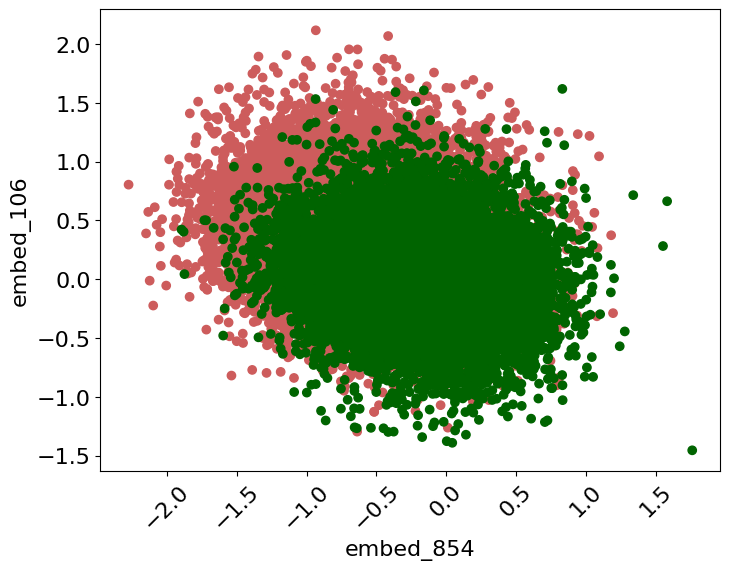

In [10]:
# plot data along top 2 most important features
import matplotlib.pyplot as plt

c_arr = np.array(["k"] * len(y))
#c_arr = [color_map[l] for l in y] 
c_arr = ["#006400" if(l == "|non_toxic|") else "#CD5C5C" for l in y]
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
plt.scatter(toxic_rail.X[sig_features.index[0]], toxic_rail.X[sig_features.index[1]], c=c_arr)
plt.xticks(rotation = 45)
plt.xlabel(sig_features.index[0])
plt.ylabel(sig_features.index[1])
plt.show()

In [11]:
toxic_rail_pred = Toxic_Rail(mode="predict")

In [14]:
text = "He is obviously a fistfuckee. He loves an arm up his ass"
toxic_rail_pred.predict(text)

array(['|toxic|obscene|insult|'], dtype=object)

In [15]:
text = "You should be kicked out, you're a moronic wimp who is too lazy to do any work. It makes me sick that people like you exist in this world."
toxic_rail_pred.predict(text)

array(['|toxic|obscene|insult|'], dtype=object)

In [16]:
text = "I want to understand how to use the classification models with embeddings to filter out toxic text"
toxic_rail_pred.predict(text)

array(['|non_toxic|'], dtype=object)